In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
df = pd.read_parquet(datafile)
df.head()

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True,43,False,worktimes,11:28:12,2
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes,11:58:33,4
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening,21:31:07,1
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True,1226,False,evening,19:35:25,6
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True,54,False,worktimes,13:39:20,6


In [3]:
def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour


df["hour"] = df["timestamp"].apply(convert_to_decimal_hours)
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
df.head()

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,log_len
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True,43,False,worktimes,11.470000,2,3.761200
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes,11.975833,4,7.996990
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening,21.518611,1,8.516593
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True,1226,False,evening,19.590278,6,7.111512
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True,54,False,worktimes,13.655556,6,3.988984


<Axes: xlabel='hour', ylabel='log_len'>

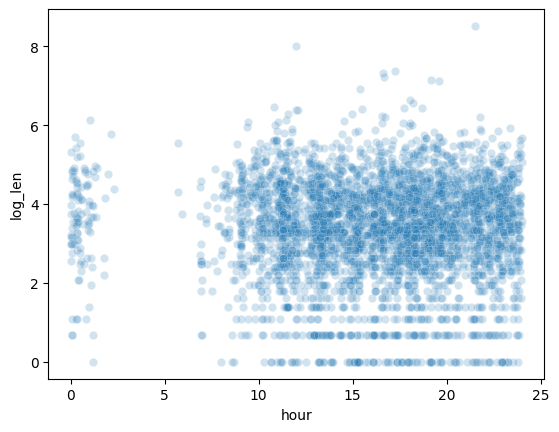

In [4]:
sns.scatterplot(data=df, x="hour", y="log_len", alpha=0.2)

,message_length,has_emoji,count
author,,,
Anja Berkemeijer,65.670875,0.367845,1188
Anthony van Tilburg,49.607843,0.271709,357
Madeleine,51.085692,0.499617,1307
Phons Berkemeijer,60.783784,0.232625,1036


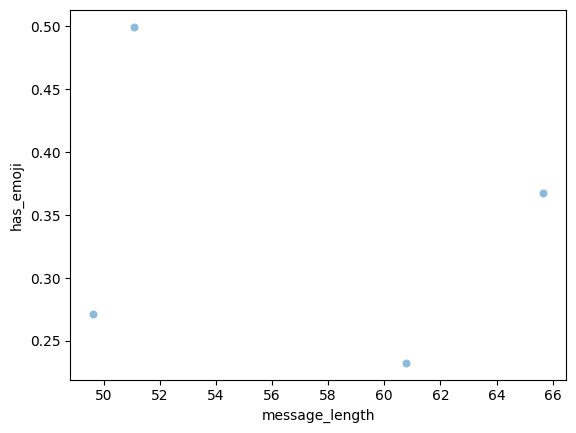

In [5]:
p = (
    df.groupby(["author"])
    .agg({"message_length": "mean", "has_emoji": "mean", "author": "count"})
    .rename(columns={"author": "count"})
)

p = p[p["count"] > 10]
sns.scatterplot(data=p, x="message_length", y="has_emoji", alpha=0.5)
p

<Axes: xlabel='message_length', ylabel='has_emoji'>

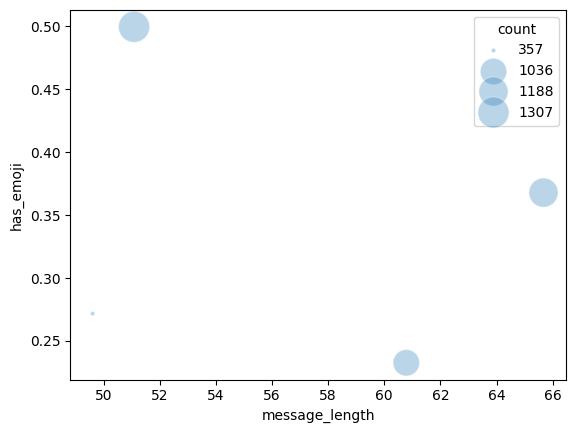

In [6]:
sns.scatterplot(data=p, x="message_length", y="has_emoji", size="count", sizes=(10, 500), alpha=0.3)

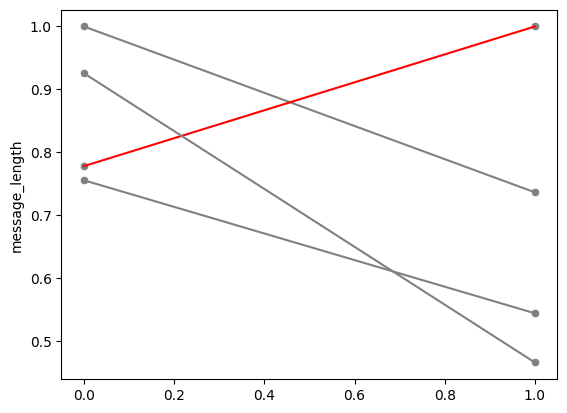

In [7]:
p["message_length"] /= p["message_length"].max()
p["has_emoji"] /= p["has_emoji"].max()
p["color"] = p.apply(lambda x: "grey" if x["message_length"] > x["has_emoji"] else "red", axis=1)

sns.scatterplot(data=p, y="message_length", x=0, color="grey")
sns.scatterplot(data=p, y="has_emoji", x=1, color="grey")
for _index, row in p.iterrows():
    sns.lineplot(x=[0, 1], y=[row["message_length"], row["has_emoji"]], color=row["color"])

# The map is not the terrain

A model is always an inaccurate representation of reality. That is not a problem, but a useful feature: the simplification of reality allows us to spot patterns and trends that might otherwise be lost in the details.

The problem is that simplifying reality always carries the risk of bending the truth to fit your story, but it isn't always obvious which model is the "best". 

In [8]:
from mads_datasets import DatasetFactoryProvider, DatasetType

penguinsdataset = DatasetFactoryProvider.create_factory(DatasetType.PENGUINS)
penguinsdataset.download_data()

df = pd.read_parquet(penguinsdataset.filepath)
select = [
    "Species",
    "Island",
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
    "Delta 15 N (o/oo)",
    "Delta 13 C (o/oo)",
    "Sex",
    "Body Mass (g)",
]
subset = df[select].dropna()

2025-10-03 15:18:51.522 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\avtnl\.cache\mads_datasets\penguins
2025-10-03 15:18:51.523 | INFO     | mads_datasets.base:download_data:124 - File already exists at C:\Users\avtnl\.cache\mads_datasets\penguins\penguins.parq


In [9]:
subset

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Sex,Body Mass (g)
1,Adelie Penguin (Pygoscelis adeliae),Torgersen,39.5,17.4,186.0,8.94956,-24.69454,FEMALE,3800.0
2,Adelie Penguin (Pygoscelis adeliae),Torgersen,40.3,18.0,195.0,8.36821,-25.33302,FEMALE,3250.0
4,Adelie Penguin (Pygoscelis adeliae),Torgersen,36.7,19.3,193.0,8.76651,-25.32426,FEMALE,3450.0
5,Adelie Penguin (Pygoscelis adeliae),Torgersen,39.3,20.6,190.0,8.66496,-25.29805,MALE,3650.0
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,38.9,17.8,181.0,9.18718,-25.21799,FEMALE,3625.0
...,...,...,...,...,...,...,...,...,...
339,Chinstrap penguin (Pygoscelis antarctica),Dream,55.8,19.8,207.0,9.70465,-24.53494,MALE,4000.0
340,Chinstrap penguin (Pygoscelis antarctica),Dream,43.5,18.1,202.0,9.37608,-24.40753,FEMALE,3400.0
341,Chinstrap penguin (Pygoscelis antarctica),Dream,49.6,18.2,193.0,9.46180,-24.70615,MALE,3775.0
342,Chinstrap penguin (Pygoscelis antarctica),Dream,50.8,19.0,210.0,9.98044,-24.68741,MALE,4100.0


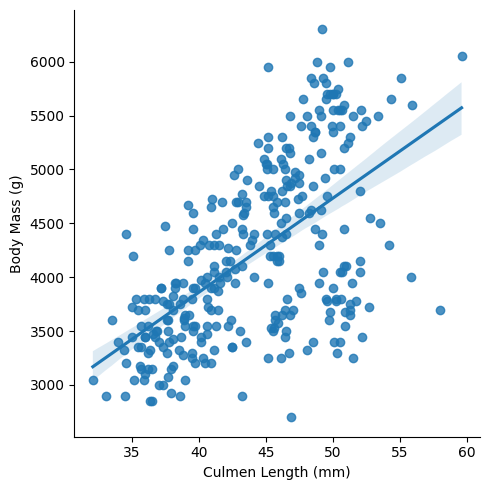

In [10]:
sns.lmplot(data=subset, x="Culmen Length (mm)", y="Body Mass (g)", fit_reg=True)

In [11]:
from scipy import stats

x = subset["Culmen Length (mm)"]
y = subset["Body Mass (g)"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"The model is y = {slope:.2f}x + {intercept:.2f}, with R^2 = {r_value**2:.2f}")

The model is y = 87.37x + 364.81, with R^2 = 0.35


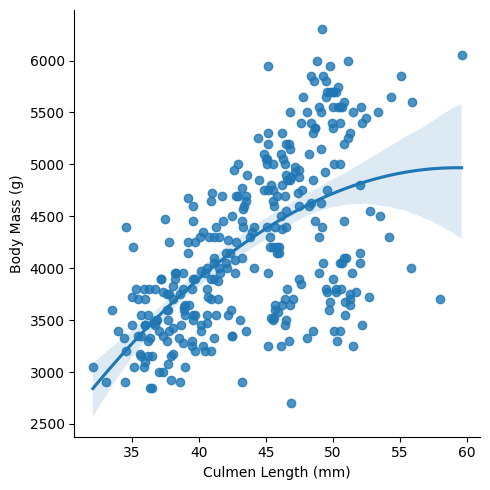

In [12]:
sns.lmplot(data=subset, x="Culmen Length (mm)", y="Body Mass (g)", order=2)

In [13]:
model = np.polyfit(x, y, 2)
print(f"The model is {model[0]:.2f}x^2 + {model[1]:.2f}x + {model[2]:.2f}")

The model is -2.88x^2 + 341.32x + -5149.05


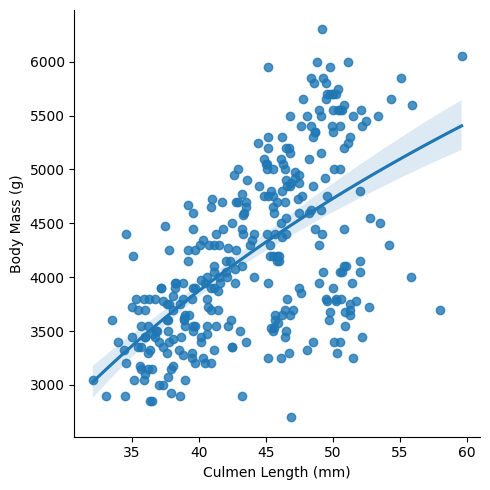

In [14]:
sns.lmplot(data=subset, x="Culmen Length (mm)", y="Body Mass (g)", logx=True)

In [15]:
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), y)
print(f"The model is y = {slope:.2f} log(x) + {intercept:.2f}, with R^2 = {r_value**2:.2f}")

The model is y = 3840.24 log(x) + -10292.81, with R^2 = 0.36


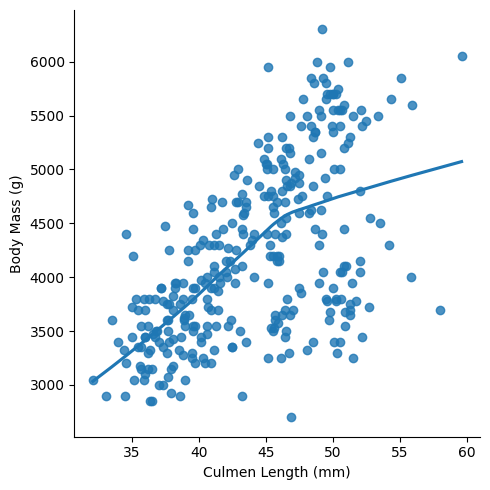

In [16]:
sns.lmplot(data=subset, x="Culmen Length (mm)", y="Body Mass (g)", lowess=True)

Lowess stands for Locally Weighted Scatterplot Smoothing, and it is a non-parametric regression method that fits a smooth curve to the data. It is a useful tool to explore the relationship between two variables, but it is not a model in the traditional sense. It is a tool to help us understand the data, not to make predictions.